# Malaria Cell Images Dataset 
##  Classifying cells with a convolutional neural network on CPU and GPU
---

## Table of Contents

* [Introduction](#section_1)

* [Data Preparation](#section_2)

* [Visualization](#section_3)

* [Building the CNN](#section_4)

* [Evaluation](#section_5)


<a id='section_1'></a>
## Introduction  

The data set contains images of of cells, which are either uninfected or infected by malaria. The goal of this project
is to build and train a convolutional neural network (CNN), to classify these cell images into the categories 'infected'
and 'uninfected. In order to do so, these images need to be loaded as numpy arrays, as the CNN takes tensors as input.
The tensors are of the shape (image height, image width and colour channels). To save memory, i chose a low resolution 
of 32x32 pixels. The cell images are in colour, so three colour channels are needed, whereas greyscale images one channel.
Therefore the input of the CNN is a tensor in the shape of (32, 32, 3).
  
The data set can be found on [Kaggle](https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria) and was taken
from the official U.S. National Library of Medicine's [website](https://ceb.nlm.nih.gov/repositories/malaria-datasets/).


<a id='section_2'></a>
## Data Preparation

In [36]:
print('Importing necessary libraries')
import numpy as np
import pandas as pd
import skimage
import matplotlib.pyplot as plt
import os
import re
import time
import gc

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras import backend as K
from numba import cuda
import tensorflow as tf

from sklearn.model_selection import train_test_split
from skimage import io

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)


Importing necessary libraries


Looking for files that do not end with '.png' and making sure, that only '.png' files are loaded.


In [37]:
oslist_cells_uninfected = os.listdir('cell_images/Uninfected')
oslist_cells_infected = os.listdir('cell_images/Parasitized')
# Testing if all files are in the format png.


def test_non_png(arr):
    for filename in arr:
        if re.match('.*\.png$', filename) is None:
            print('\n' + filename+' is not a .png file')
            print('Removing ' + filename + ' from array.')
            arr.remove(filename)
    print('All files are in the format \'.png\'.')


test_non_png(oslist_cells_uninfected)
print('\nNumber of uninfected cells: {}'.format(len(oslist_cells_uninfected))+'\n')

test_non_png(oslist_cells_infected)
print('\nNumber of infected cells: {}'.format(len(oslist_cells_infected))+'\n')



Thumbs.db is not a .png file
Removing Thumbs.db from array.
All files are in the format '.png'.

Number of uninfected cells: 13779


Thumbs.db is not a .png file
Removing Thumbs.db from array.
All files are in the format '.png'.

Number of infected cells: 13779



Images are loaded with the scikit-image library and resized to 32x32 pixels. The images are located in folders for A numpy array of the cell image's labels 
is created, which will be used as the target vector later on. The values '0' and '1' in the numpy array 'labels' are used
to label the cell images as uninfected and infected respectively.
  
The data is split into a train and test set, using scikit-learn's train_test_split.


In [38]:
start = time.time()

cell_images = list()
new_size = (32, 32)

# Loading the images.
for i in oslist_cells_uninfected:
    image = io.imread(os.path.join('cell_images/Uninfected', i))
    image_resized = skimage.transform.resize(image, new_size)
    cell_images.append(image_resized)

for j in oslist_cells_infected:
    image = io.imread(os.path.join('cell_images/Parasitized', j))
    image_resized = skimage.transform.resize(image, new_size)
    cell_images.append(image_resized)

# Converting the list into an numpy array.
cell_images = np.array(cell_images)
# Creating numpy array with labels for infection status of each cell image.
labels = np.append(np.zeros(len(oslist_cells_uninfected)), np.ones(len(oslist_cells_infected)))
# labels = to_categorical(labels, num_classes=2)

print('Shape of cell images: {}'.format(cell_images.shape))
print('Shape of labels: {}'.format(labels.shape))

# Creating train and test split.
X_train, X_test, y_train, y_test = train_test_split(cell_images, labels, random_state=121, test_size=0.2)

print('\nRemoving variables \'cell_images\' and \'labels\', to free memory.')
del(cell_images, labels)

end = time.time()
print('\nTime to load data:\n {}sec'.format(round(end - start, 2)))



Shape of cell images: (27558, 32, 32, 3)
Shape of labels: (27558,)

Removing variables 'cell_images' and 'labels', to free memory.

Time to load data:
 155.37sec


<a id='section_3'></a>
## Visualization

The twenty images below are ten random samples of uninfect and infected cell images. All infected cells have a purple mark in differing sizes and intensities, which is used to identify the presence of malaria.


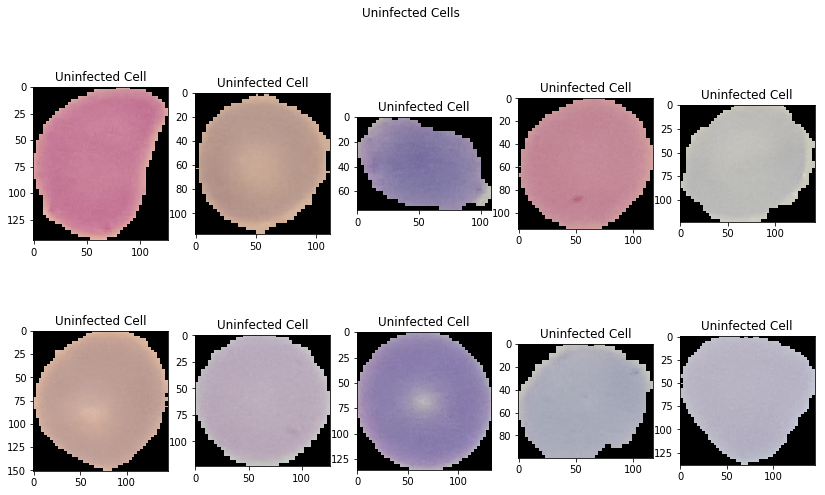

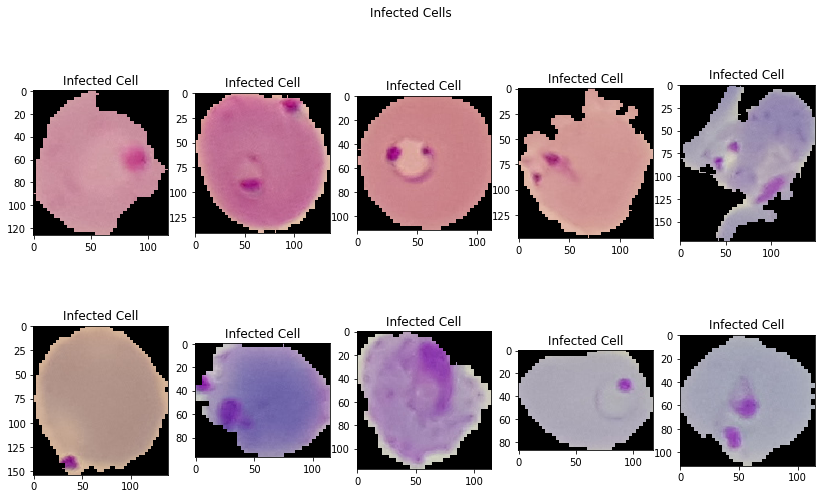

Time to load data:
 3.58sec


In [39]:
start = time.time()
# Comparing images of uninfected and infected cells.

np.random.seed(0)
random_file_number = np.random.randint(13780, size=21)
plt.figure(figsize=(14, 8))
plt.suptitle('Uninfected Cells')
for i in range(1, 11):
    plt.subplot(2, 5, i)
    np.random.seed(i)
    image = io.imread(os.path.join('cell_images/Uninfected', oslist_cells_uninfected[random_file_number[i]]))
    plt.imshow(image)
    plt.title('Uninfected Cell')
plt.show()

plt.figure(figsize=(14, 8))
plt.suptitle('Infected Cells')
for i in range(1, 11):
    plt.subplot(2, 5, i)
    np.random.seed(i)
    image = io.imread(os.path.join('cell_images/Parasitized', oslist_cells_infected[random_file_number[i]]))
    plt.imshow(image)
    plt.title('Infected Cell')
plt.show()

end = time.time()

print('Time to load data:\n {}sec'.format(round(end - start, 2)))

<a id='section_4'></a>
## Building the CNN

The model is build with the introduction to convolutional neural networks on TensorFlow's [website]( thehttps://www.tensorflow.org/alpha/tutorials/images/intro_to_cnns).  
 
We will use `Sequential()` to build a CNN. The `input_shape` needs to be provided in the first layer, in our case a `2D convolutional layer`. A matrix operation is performed on a 3x3-pixel subset of the image and a 3D tensor returned. In the next layer, a `max pooling operation` is performed on the spatial data, in which the output of the previous layer is taken as input and a downsampled 3D tensor returned.
  
We `Flatten()` the 3D output of our last convolutional base of the shape `4 x 4 x 64` to a 1D vector and add two `Dense` layers. The output of our last `Dense` layer will be the classification for our two classes, `infected` and `uninfected`.



#### Training on CPU

To compare the time to train on the GPU and CPU, we will use the same architecture of the CNN in both cases.


In [40]:
start = time.time()

with tf.device('/cpu:0'):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    model.summary()
    model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=5)

end = time.time()
print('\n\nTime to train CNN with CPU:\n {}sec'.format(round(end - start, 2)))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                65600     
__________

#### Training on GPU

In [41]:
print('GPU available:\n{}'.format(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)))


GPU available:
True


In [42]:
start = time.time()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
   
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.summary()
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

end = time.time()
print('\n\nTime to train CNN with GPU:\n {}sec'.format(round(end - start, 2)))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_5 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                65600     
__________

In [43]:
print(model.evaluate(X_test, y_test))




5512/5512 [==============================] - 0s 75us/step
[0.15617888761449103, 0.9482946298984035]


<a id='section_5'></a>
## Evaluation

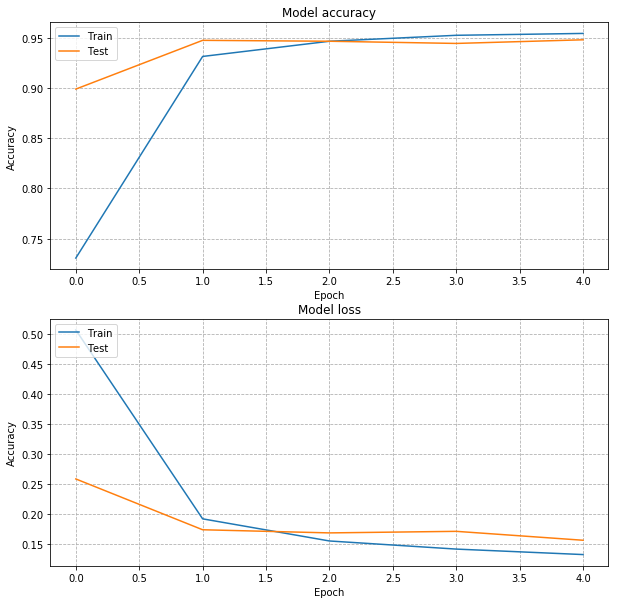

In [44]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(linestyle='--')
plt.legend(['Train', 'Test'], loc='upper left')
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(linestyle='--')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [45]:
from sklearn.metrics import classification_report

threshold = 0.8

pred = model.predict(X_test)[:,1]

y_predict = [int(pred>threshold) for pred in pred]

print(classification_report(y_test, y_predict))


              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94      2793
         1.0       0.98      0.89      0.93      2719

   micro avg       0.94      0.94      0.94      5512
   macro avg       0.94      0.94      0.94      5512
weighted avg       0.94      0.94      0.94      5512

